In [1]:
from pathlib import Path
import pandas as pd
from ast import literal_eval
import numpy as np
import json
import itertools

## 1. Get reference metabolic model from BiGG

Download:

1. current version of BiGG
2. metabolites for model organism iMM1415 (the only mouse model at this point)

In terminal using BiGG API
```
curl http://bigg.ucsd.edu/api/v2/models/iMM1415/metabolites > iMM1415_metabolites.json
curl http://bigg.ucsd.edu/api/v2/database_version > bigg_version.txt
```

3. metadata for all metabolites in BiGG (for mapping to other databases)

Got to http://bigg.ucsd.edu/data_access and download universal_model.json


- Inputs

In [ ]:
p_root_dir = Path.cwd().parents[1]
p_data = p_root_dir / "5_data"
p_analysis = p_root_dir / r"6_figures/figure_2/metabolites_in_chemical_space"

# metabolites for model organism iMM1415
p_mouse = p_analysis / "iMM1415_metabolites.json" 
# metadata for all metabolites in BiGG 
p_mapping = p_analysis / "universal_model.json"

# mapping of current HMDB ids to: old HMDB ids, molecule names, KEGG ids
p_hmdb_ids = p_analysis / "hmdb_secondary_2020-09-09.csv"
p_hmdb_names = p_analysis / "hmdb_name_2020-09-09.csv"
p_hmdb_kegg = p_analysis / "hmdb_kegg_2020-09-09.csv"

### Get mouse model metabolites and their mapping to BiGG and other IDs using downloaded files

- Get BiGG id to metadata mapping from universal_model.json

In [ ]:
with open(str(p_mapping)) as json_file:
    mapping = json.load(json_file)
    
primary = []
secondary = []
names = []
hmdbs = []
keggs = []
lms = []
inchi_keys = []

for i in mapping['metabolites']:
    
    primary.append(i['id'])
    secondary.append(i['notes']['original_bigg_ids'])
    names.append(i['name'])
    
    hmdb = [x[1].split('/')[-1] for x in i['annotation'] if 'Human Metabolome Database' in x]
    kegg = [x[1].split('/')[-1] for x in i['annotation'] if 'KEGG Compound' in x]
    lm = [x[1].split('/')[-1] for x in i['annotation'] if 'LipidMaps' in x]
    inchi_key = [x[1].split('/')[-1] for x in i['annotation'] if 'InChI Key' in x]
    hmdbs.append(hmdb)
    keggs.append(kegg)
    lms.append(lm)
    inchi_keys.append(inchi_key)

universal = pd.DataFrame.from_dict({
    'name' : names,
    'bigg_id' : primary,
    'bigg_accessions' : secondary,
    'hmdb_secondary' : hmdbs,
    'kegg_id' : keggs,
    'lipidmaps_id' : lms,
    'inchi_key' : inchi_keys
})
universal.head()

- Get unique metabolite BiGG ids for mouse

In [ ]:
with open(str(p_mouse)) as json_file:
    mouse = json.load(json_file)

mouse_metabs = list(set( [x['bigg_id'] for x in mouse['results']] ))
print(f"{len(mouse_metabs)} metabolites found")

- Map metadata for mouse ids

In [ ]:
for molecule in mouse_metabs:
    universal.loc[universal.bigg_accessions.apply(lambda x: molecule in x), 'mouse_model'] = molecule

data_mouse = universal.dropna(subset=['mouse_model'])
data_mouse.head()

Universal model sometimes has several identifiers for the same molecule. Here we make sure one row is one unique molecule.

In [ ]:
# Group duplicated metabolites
f = lambda x: list(set(sum(list(x), [])))

data_mouse = data_mouse.groupby('mouse_model').agg({
    
    'name':';'.join,
    'bigg_accessions':f, 
    'hmdb_secondary':f,
    'kegg_id':f,
    'lipidmaps_id':f,
    'inchi_key':f
})

data_mouse.name = data_mouse.name.apply(lambda x: list(set(x.split(';'))))

# convert all missing values to nan 
for c in data_mouse.columns:
    data_mouse[c] = data_mouse[c].apply(lambda x: x if x != [] else np.nan)
    
data_mouse.head()

- Remove metabolites for which no id and InChI key mapping is available

In [ ]:
mapping_missing = data_mouse[['hmdb_secondary', 'lipidmaps_id', 'kegg_id', 'inchi_key']].isna().all(axis=1)
data_mouse = data_mouse[~mapping_missing]
print(f"{len(data_mouse)} metabolites left")

### Map every metabolite to HMDB id if possible

- Remove a duplicate entry for water

In [ ]:
data_mouse.drop(['oh1'], axis=0, inplace=True)

- Update HMDB IDs to the newest currently available

In [ ]:
hmdb_ids = pd.read_csv(p_hmdb_ids) 

for i, row in data_mouse.iterrows():

    if row.hmdb_secondary == row.hmdb_secondary: # skip rows with no HMDB id
        
        primary_id = list()
        for j in row.hmdb_secondary:
            flag = 0
            
            for _, r in hmdb_ids.iterrows():
                if j in literal_eval(r.hmdb_secondary):
                    primary_id.append([r.hmdb_primary])
                    # since one old id becomes only one new id, break out of the loop after one match has been found
                    flag = 1
                    break
                    
#             if flag == 0:
#                 print(f"Mapping for {j} ({i}) not found")                  
        data_mouse.at[i, 'hmdb_primary'] = list(set(sum(list(primary_id), [])))

In [ ]:
# This code needs to be run again to avoid a bug where first row of the dataframe has a wrong format

for i, row in data_mouse.iterrows():

    if row.hmdb_secondary == row.hmdb_secondary: # skip rows with no HMDB id
        
        primary_id = list()
        for j in row.hmdb_secondary:
            flag = 0
            
            for _, r in hmdb_ids.iterrows():
                if j in literal_eval(r.hmdb_secondary):
                    primary_id.append([r.hmdb_primary])
                    # because one old id becomes only one new id, break out of the loop after one match has been found
                    flag = 1
                    break
                    
            if flag == 0:
                print(f"Mapping for {j} ({i}) not found")                  
        data_mouse.at[i, 'hmdb_primary'] = list(set(sum(list(primary_id), [])))
        break

Some BiGG metabolite entries had no HMDB ID but did have KEGG ID
- Do an  additional mapping through kegg to modern HMDB

In [ ]:
hmdb_kegg = pd.read_csv(p_hmdb_kegg)

for i, row in data_mouse.loc[data_mouse.hmdb_primary.isna()].iterrows():

    if row.kegg_id == row.kegg_id: # skip rows with no KeGG id
        
        primary_id = []
        for j in row.kegg_id:
            flag = 0
            
            for _, r in hmdb_kegg.iterrows():
                if j == r.kegg_id:
                    primary_id.append(r.hmdb_primary)
                    # because one old id becomes only one new id, break out of the loop after one match has been found
                    flag = 1
                    break
                                  
        data_mouse.at[i, 'hmdb_primary'] = list(set(primary_id))

After updating to new HMDB ids there are still some inconsistencies due:
- duplicate entries in HMDB
- erroneous entries in BiGG

Manual curation was used to find single id that would match unresolved cases

In [ ]:
# # code to generate clickable links for HMDB ids

# from IPython.core.display import display, HTML
# test = ['HMDB0000301', 'HMDB0062562']
# [display(HTML(f"<a href=\042https://hmdb.ca/metabolites/{x}\042>{x}</a>")) for x in test]

In [ ]:
curated_ids = dict({
     'HMDB0005971' : ['HMDB0005971', 'HMDB0062803', 'HMDB0006511'],
     'HMDB0002054' : ['HMDB0062753', 'HMDB0002054'], 
     'HMDB0003391' : ['HMDB0000362', 'HMDB0003391'],
     'HMDB0001480' : ['HMDB0001480', 'HMDB0062571'],
     'HMDB0003937' : ['HMDB0062368', 'HMDB0003937'],
     'HMDB0060241' : ['HMDB0060241', 'HMDB0062371'],
     'HMDB0001268' : ['HMDB0062563', 'HMDB0001268'],
     'HMDB0006467' : ['HMDB0060140', 'HMDB0006467'],
     'HMDB0001014' : ['HMDB0062719', 'HMDB0001014'],
     'HMDB0006273' : ['HMDB0062424', 'HMDB0006273'],
     'HMDB0001299' : ['HMDB0062647', 'HMDB0001299'],
     'HMDB0001316' : ['HMDB0001316', 'HMDB0062800'],
     'HMDB0001127' : ['HMDB0062628', 'HMDB0001127'],
     'HMDB0001200' : ['HMDB0060485', 'HMDB0001200'],
     'HMDB0001550' : ['HMDB0062625', 'HMDB0001550'],
     'HMDB0006480' : ['HMDB0059626', 'HMDB0006480'],
     'HMDB0000215' : ['HMDB0000215', 'HMDB0062641'],
     'HMDB0001062' : ['HMDB0002817', 'HMDB0001062'],
     'HMDB0000161' : ['HMDB0062251', 'HMDB0000161'],
     'HMDB0001211' : ['HMDB0006502', 'HMDB0001211'],
     'HMDB0000517' : ['HMDB0062762', 'HMDB0000517'],
     'HMDB0000191' : ['HMDB0062186', 'HMDB0000191', 'HMDB0062501'],
     'HMDB0002009' : ['HMDB0062466', 'HMDB0002009'],
     'HMDB0002306' : ['HMDB0000492', 'HMDB0002306'],
     'HMDB0000062' : ['HMDB0000062', 'HMDB0002095'],
     'HMDB0003712' : ['HMDB0003712', 'HMDB0011689'],
     'HMDB0001264' : ['HMDB0062706', 'HMDB0001264'],
     'HMDB0001439' : ['HMDB0062708', 'HMDB0001439'],
     'HMDB0000148' : ['HMDB0060475', 'HMDB0000148'],
     'HMDB0000139' : ['HMDB0000138', 'HMDB0000139'],
     'HMDB0000125' : ['HMDB0062697', 'HMDB0000125'],
     'HMDB0002111' : ['HMDB0001039', 'HMDB0002111'],
     'HMDB0059634' : ['HMDB0012238', 'HMDB0059634'],
     'HMDB0000211' : ['HMDB0000211', 'HMDB0034220'],
     'HMDB0000687' : ['HMDB0000687', 'HMDB0010346'],
     'HMDB0001066' : ['HMDB0062624', 'HMDB0001066'],
     'HMDB0004321' : ['HMDB0003375', 'HMDB0004321', 'HMDB0032473'],
     'HMDB0001451' : ['HMDB0014312', 'HMDB0001451'],
     'HMDB0001064' : ['HMDB0062491', 'HMDB0001064'],
     'HMDB0006290' : ['HMDB0062490', 'HMDB0006290'],
     'HMDB0000182' : ['HMDB0000182', 'HMDB0003405'],
     'HMDB0000696' : ['HMDB0000696', 'HMDB0033951'],
     'HMDB0001354' : ['HMDB0062623', 'HMDB0001354'],
     'HMDB0000898' : ['HMDB0061685', 'HMDB0000898', 'HMDB0001861', 'HMDB0062574'],
     'HMDB0000213' : ['HMDB0000213', 'HMDB0006814'],
     'HMDB0003502' : ['HMDB0003502', 'HMDB0006230'],
     'HMDB0000051' : ['HMDB0000051', 'HMDB0041827'],
     'HMDB0006529' : ['HMDB0006529', 'HMDB0062633'],
     'HMDB0000209' : ['HMDB0000209', 'HMDB0040733'],
     'HMDB0001134' : ['HMDB0062646', 'HMDB0001134'],
     'HMDB0003555' : ['HMDB0004198', 'HMDB0003555'],
     'HMDB0003484' : ['HMDB0003484', 'HMDB0062692'],
     'HMDB0001338' : ['HMDB0059623', 'HMDB0001338'],
     'HMDB0001128' : ['HMDB0062576', 'HMDB0001128'],
     'HMDB0000280' : ['HMDB0062643', 'HMDB0000280'],
     'HMDB0001431' : ['HMDB0062696', 'HMDB0001431'],
     'HMDB0001372' : ['HMDB0062636', 'HMDB0001372'],
     'HMDB0000929' : ['HMDB0000929', 'HMDB0030396'],
     'HMDB0000257' : ['HMDB0060293', 'HMDB0000257'],
     'HMDB0000290' : ['HMDB0000290', 'HMDB0000304'],
     'HMDB0000301' : ['HMDB0062562', 'HMDB0000301'],
     'HMDB0001554' : ['HMDB0062755', 'HMDB0001554'],
     'HMDB0000163' : ['HMDB0037138', 'HMDB0000163']
})

In [ ]:
# replace primary hmdb_id according to the curated list
for k, v in curated_ids.items():
    for p in itertools.permutations(v):
        for _, row in data_mouse.iterrows():
            if list(p) == row.hmdb_primary:
                row.hmdb_primary = [k]
                break
                
data_mouse.hmdb_primary = data_mouse.hmdb_primary.apply(lambda x: x if x != [] else np.nan)
data_mouse[data_mouse.hmdb_primary.isna()].to_csv(p_analysis / 'mouse_metabolites_for_inspection.csv')

- Look at unannotated metabolites, find HMDB IDs for them manually, drop the rest (too generic or not metabolites)

In [ ]:
addition = dict({
    '3mop':'HMDB0000491',
    'acgal':'HMDB0000853',
    'arab__L':'HMDB0000646',
    'btamp':'HMDB0004220',
    'cbl2':'HMDB0002174',
    'dhbpt':'HMDB0002215',
    'fdp':'HMDB0001058',
    'glyald':'HMDB0001051',
    'thm':'HMDB0000235',
    'xu1p__D':'HMDB0006534',
    'fru':'HMDB0001076',
    
    # correct misannotated metabolites (due to wrong HMDB ID in BiGG) that are causing duplicates in primary is column
    'fuc__L':'HMDB0000174', 
    'mi3p__D':'HMDB0006814'
})

# add missing ids
for k,v in addition.items():
    data_mouse.at[k, 'hmdb_primary'] = [v]
    
# remove the rest (generic or not metabolites)
data_mouse = data_mouse[~data_mouse.hmdb_primary.isna()]

# clean up the format
for _, row in data_mouse.iterrows():
    if row.hmdb_primary == row.hmdb_primary:
        row.hmdb_primary = row.hmdb_primary[0]

#save
data_mouse.to_csv(p_analysis / 'data_mouse.csv')

## 2. Use BiGG mouse metabolites to create chemical space. Locate spotted standards in this chemical space

In [2]:
from rdkit import Chem, RDLogger, DataStructs
from rdkit.Chem import AllChem, PandasTools, Draw
from matplotlib import animation
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import rc

rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':16})
rc('pdf', fonttype=42)
rc('ps', fonttype=42)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


- Inputs

### Prepare data

In [3]:
p_root_dir = Path.cwd().parents[1]
p_analysis = p_root_dir / r"6_figures/figure_2/metabolites_in_chemical_space"
p_data = p_root_dir / "5_data"

# mouse metabolites from BiGG
p_data_mouse = p_analysis / 'data_mouse.csv'

# mapping of HMDB ids to SMILES
p_hmdb_smiles = p_analysis / "hmdb_smiles_2020-09-09.csv"

# standards
p_compounds = p_root_dir / r"5_data/metadata/compounds_ids.csv"
p_chem_class = p_root_dir / r"5_data/custom_classification/custom_classification.csv"

- Map chemical classes to standards

In [4]:
compounds = pd.read_csv(p_compounds, index_col='internal_id')
chem_class = pd.read_csv(p_chem_class)

compound_class = pd.merge(compounds, chem_class, how='left', on='name_short')

# drop thermometer ions, blank, fiducials, off-sample entries and some columns
compound_class = compound_class[compound_class.hmdb_primary != 'custom']
compound_class = compound_class[['internal_id', 'name_short', 'hmdb_primary', 'coarse_class', 'fine_class']]

- Map smiles to standards and mouse metabolites

In [5]:
smiles = pd.read_csv(p_hmdb_smiles)

# Map standards to smiles
compound_smiles = pd.merge(compound_class, smiles, on='hmdb_primary', how='left')
compound_smiles['type'] = 'standards'

# Map mouse metabolites to smiles
data_mouse = pd.read_csv(p_data_mouse)
mouse_smiles = pd.merge(data_mouse, smiles, on='hmdb_primary', how='left')
mouse_smiles = mouse_smiles[['name', 'hmdb_primary', 'smiles']]

# Merge into one data frame
df = pd.merge(compound_smiles, mouse_smiles, how='outer', on='hmdb_primary')
df.loc[~(df.type == 'standards'), 'type'] = 'reference'
# clean up columns
df['mol_name'] = df.name_short.combine_first(df.name_short)
df.mol_name = df.mol_name.apply(lambda x: x[0] if type(x) == list else x)
df['smiles'] = df.smiles_x.combine_first(df.smiles_y)
df.drop(['smiles_x', 'smiles_y', 'name', 'name_short'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,internal_id,hmdb_primary,coarse_class,fine_class,type,mol_name,smiles
0,0.0,HMDB0000122,Carbohydrates,Carbohydrates,standards,Glucose,OC[C@H]1O[C@@H](O)[C@H](O)[C@@H](O)[C@@H]1O
1,1.0,HMDB0001401,Carbohydrates,Carbohydrate phosphates,standards,Glucose 6-phosphate,OC1O[C@H](COP(O)(O)=O)[C@@H](O)[C@H](O)[C@H]1O
2,3.0,HMDB0001058,Carbohydrates,Carbohydrate phosphates,standards,"Fructose 1,6-bisphosphate",O[C@H]1[C@H](O)[C@@](O)(COP(O)(O)=O)O[C@@H]1CO...
3,4.0,HMDB0001473,Carbohydrates,Carbohydrate phosphates,standards,Dihydroxyacetone phosphate,OCC(=O)COP(O)(O)=O
4,7.0,HMDB0000807,Carboxylic acids,Carboxylic acid phosphate,standards,3-Phosphoglyceric acid,OC(COP(O)(O)=O)C(O)=O


In [6]:
# Check for invalid smiles
c_smiles = []

# test
# for ds in ['COH', 'C=O', 'C(O)']:

for ds in df.smiles:
    try:
        cs = Chem.CanonSmiles(ds)
        c_smiles.append(cs)
    except:
        print('Invalid SMILES:', ds)

- Convert smiles to mol and calculate Morgan fingerprints

In [7]:
PandasTools.AddMoleculeColumnToFrame(df,'smiles','mol', includeFingerprints=True)

fps = []
bis = []

for i, mol in enumerate(df.mol):
    
    bi = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 1, 2048, bitInfo = bi) # radius=2 is another resaonable option
    
    fps.append(fp)
    bis.append(bi)
    
    bi=None
    
df['fp'] = fps # what you write into df is not the same
df['bi'] = bis

In [8]:
df.to_pickle(p_analysis / "fingerprints_chemdraw.pickle")

### Make plots

In [9]:
from matplotlib import markers

Define colour schemes:

Two-colour for standards vs mouse metabolite reference
8-colour for chemical classes of standards, and mouse metabolite reference

Paul Toll palette:
- #117733 green
- #999933 olive
- #AA4499 purple
- #88CCEE cyan
- #44AA99 teal
- #CC6677 rose
- #332288 indigo
- #DDCC77 sand
- #882255 wine
- #DDDDDD pale grey

In [10]:
c2 = ['#f1a340' if x=='standards' else '#998ec3' for x in df.type]
df['colour2'] = c2

colours = dict({ #Paul Tol palette for colour blindness
     "Amines":'#DDCC77', #yellow
     "Amino acids, peptides, and analogues":'#332288', #blue
     "Carbohydrates":'#117733', #green
     "Carboxylic acids":'#44AA99', #emerald
     "Lipids and lipid-like molecules":'#AA4499', #magenta
     "Nucleosides, nucleotides, and analogues":'#CC6677', #light red
     "Vitamins and cofactors":'#88CCEE', #lightblue
    })

c7 = [colours[t] if t==t else '#DDDDDD' for t in df.coarse_class]
df['colour7'] = c7

- Save data for plot generation

In [11]:
df.to_pickle(p_analysis / "data_for_PCA.pickle")

- Plot PCA

In [16]:
# # We make the 2D PCA plot
# print("Drawing the 2D PCA plot")
# pca = PCA(n_components=2)
# fp_pca = pca.fit_transform(list(df.fp.values))

# fig, ax = plt.subplots()
# ax.scatter(*fp_pca.transpose(), c=c7, alpha = 0.7)
# ax.set_xlabel("PC1")
# ax.set_ylabel("PC2")
# ax.set_title('2D PCA plot')
# plt.show()
# # fig.savefig(p_analysis / "pca_2d_classes.png")

In [17]:
# We make the 2D PCA plot
print("Drawing the 2D PCA plot")
pca = PCA(n_components=3)
fp_pca = pca.fit_transform(list(df.fp.values))

# PC1 vs PC2
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))

ax[0].scatter(*fp_pca[:, 0:2].transpose(), c=c7, alpha = 0.85)
ax[0].set_xlabel("PC1")
ax[0].set_ylabel("PC2")

# PC2 vs PC3
ax[1].scatter(*fp_pca[:, 1:3].transpose(), c=c7, alpha = 0.85)
ax[1].set_xlabel("PC2")
ax[1].set_ylabel("PC3")

fig.suptitle('2D PCA plot')

plt.close()
# fig.savefig(p_analysis / "pca_2d_classes.png")

Drawing the 2D PCA plot


In [18]:
print(f"Loadings in % {np.around(pca.explained_variance_ratio_ *100,1)}")

Loadings in % [23.   8.   5.5]


In [19]:
# # We make the 3D PCA plot
# print("Drawing the 3D PCA plot")
# pca = PCA(n_components=3)
# fp_pca = pca.fit_transform(list(df.fp.values))
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(5,5))
# ax.scatter(*fp_pca.transpose(), c=c7, s=25)
# ax.set_xlabel("PC1", labelpad=10)
# ax.set_ylabel("PC2", labelpad=10)
# ax.set_zlabel("PC3", labelpad=10)
# ax.set_title('3D PCA plot')
# # ax.set_xlim(-1,3.5)
# # ax.azim = 210
# # ax.elev = 30
# plt.show()
# # fig.savefig(p_analysis / "pca_3d_classes.pdf")

In [20]:
# def animate(i):
#     ax.view_init(elev=10., azim=i)
#     return fig,

# # Animate
# anim = animation.FuncAnimation(fig, animate, frames=360, interval=20, blit=True)
# writergif = animation.PillowWriter(fps=30)
# # anim.save(p_analysis / "pca_3d_classes.gif",writer=writergif)

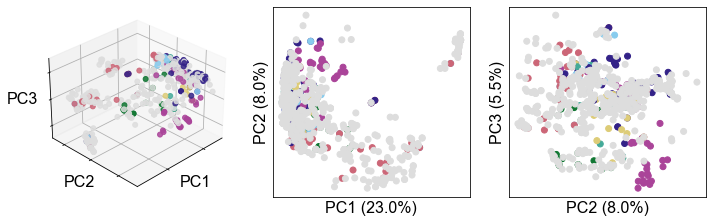

In [21]:
# Make a panel
pca = PCA(n_components=3)
fp_pca = pca.fit_transform(list(df.fp.values))

pca_3d = PCA(n_components=3)
fp_pca_3d = pca_3d.fit_transform(fps)

fig = plt.figure(figsize=(12, 3.5))

# 3D PCA
ax = fig.add_subplot(1, 3, 1, projection='3d')
ax.scatter(*fp_pca_3d.transpose(), c=c7, s=25, alpha=0.85)
ax.set_xlabel("PC1", labelpad=-5)
ax.set_ylabel("PC2", labelpad=-5)
ax.set_zlabel("PC3", labelpad=-5)
ax.set_xlim(-1,3.5)
ax.azim = 45
ax.elev = 30
ax.grid(True)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

# PC1 vs PC2
ax = fig.add_subplot(1, 3, 2)
ax.scatter(*fp_pca[:, 0:2].transpose(), c=c7, alpha = 1)
ax.set_xlabel("PC1 (23.0%)")
ax.set_ylabel("PC2 (8.0%)")
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

# PC2 vs PC3
ax = fig.add_subplot(1, 3, 3)
ax.scatter(*fp_pca[:, 1:3].transpose(), c=c7, alpha = 1)
ax.set_xlabel("PC2 (8.0%)")
ax.set_ylabel("PC3 (5.5%)")
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.show()
fig.savefig(p_analysis / "pca_panel_with_precent.png")
fig.savefig(p_analysis / "pca_panel_with_precent.pdf", transparent=True)